In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Understanding the data

In [2]:
data = pd.read_csv('train.csv')
unseen = pd.read_csv('test.csv')
sample = pd.read_csv('sample.csv')
data_dict = pd.read_csv('data_dictionary.csv')
# data.head()

In [3]:
data.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)

In [4]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data1 = data[variables].set_index('id')

data1.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


In [5]:
data1.columns

Index(['circle_id', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'churn_probability'],
      dtype='object')

In [6]:
date_columns = ['last_date_of_month_6', 'last_date_of_month_7',
            'last_date_of_month_8', 'date_of_last_rech_6',
            'date_of_last_rech_7', 'date_of_last_rech_8']
data[date_columns] = data[date_columns].apply(pd.to_datetime)

data_types = data.dtypes
data_types = pd.DataFrame(data_types)
# data[date_columns].head()

In [7]:
data_types = data.dtypes
data_types = pd.DataFrame(data_types)
# data_types.head()

# Preporcessing

### Handling Missing Values

In [8]:
# Finding the columns having more than 70% missing values
pd.set_option('display.max_rows', None)
columns = data.columns
drop_feature = []

for feature in columns:
    if round(data[feature].isna().sum() / data.shape[0] * 100, 2) > 70:
        drop_feature.append(feature)
        
# print(drop_feature)

In [9]:
data = data.drop(drop_feature, axis=1)
unseen = unseen.drop(drop_feature, axis=1)
data.shape, unseen.shape

((69999, 142), (30000, 141))

In [10]:
# round(data.isna().sum() / data.shape[0] * 100, 0)

In [11]:
# Relacing missing values by median

columns = data.columns
for feature in columns:
    data[feature].fillna(data[feature].median(), inplace=True)

# data.isna().sum()

### Checking Duplicates

In [12]:
# Dropping duplicate rows
data = data.drop_duplicates()
unseen = unseen.drop_duplicates()
data.shape, unseen.shape

((69999, 142), (30000, 141))

### Dropping the columns having single value 

In [13]:
# (checking for column having only 1 value)

columns = data.columns
drop_feature = []
for feature in columns:
    if data[feature].nunique() == 1:
        drop_feature.append(feature)
        
print('These features have single value : ')
print(drop_feature)

data = data.drop(drop_feature, axis=1)
unseen = unseen.drop(drop_feature, axis=1)
data.shape, unseen.shape

These features have single value : 
['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


((69999, 129), (30000, 128))

### Renaming last 3 features

In [14]:
columns = data.columns.to_list()
columns[-2] = 'vbc_3g_6'
columns[-3] = 'vbc_3g_7'
columns[-4] = 'vbc_3g_8'

data.columns = columns
# data.head()

## Data Visualization

In [15]:
## plotting scateer plot and box plots
# columns = data.columns
# columns = [x for x in columns if x not in date_columns]

# for feature in columns:
#     print(feature)
#     print('unique vaules = ', data[feature].nunique())
    
#     fig, axs = plt.subplots(1,2, figsize=(12,3))
#     sns.scatterplot(data=data, x='id', y=feature, ax=axs[0])
#     axs[0].set_title(feature)    
    
#     sns.boxplot(data=data, y=feature, ax=axs[1])
#     plt.show()
    
#     print('-' * 75)
    

In [16]:
# data.nunique()

### Handling Outliers

In [17]:
for feature in data.columns:
    if feature == 'churn_probability':
        continue
    
    lower_limit = data[feature].mean() - (2 * data[feature].std())
    upper_limit = data[feature].mean() + (2 * data[feature].std())
    
    data[feature] = data[feature].apply(lambda x: min(x, upper_limit) if x > upper_limit else max(x, lower_limit))

In [18]:
# data.head()

### Dummy Variables - One Hot Encoding

- There are only numerical columns. these is no categorical variable. no need of dummy variables encoding.  
- Date columns need to consider as categorical variable.

## Taking Average of 6th, 7th and 8th month

In [19]:
# Separating 6th, 7th and 8th month data
jun = []
jul = []
aug = []

columns = data.columns
for feature in columns:
    if feature[-1] == '6':
        jun.append(feature)
    elif feature[-1] == '7':
        jul.append(feature)
    elif feature[-1] == '8':
        aug.append(feature)
        
print(jun)
print(jul)
print(aug)

['arpu_6', 'onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 'std_og_mou_6', 'isd_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_mou_6', 'total_ic_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6', 'ic_others_6', 'total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'date_of_last_rech_6', 'last_day_rch_amt_6', 'vol_2g_mb_6', 'vol_3g_mb_6', 'monthly_2g_6', 'sachet_2g_6', 'monthly_3g_6', 'sachet_3g_6', 'vbc_3g_6']
['arpu_7', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_7',

In [20]:
data2 = pd.DataFrame()

for i in range(0, len(jun)): 
    feature = jun[i][:-2]
    if feature == 'date_of_last_rech': # skipping date column
        continue
    data2[feature] = (data[jun[i]] + data[jul[i]] + data[aug[i]]) / 3
    
data2['churn_probability'] = data['churn_probability']
# data2.head()

### Final data set

In [21]:
df_final = data2.copy()

# Train test split

In [22]:
train_df, test_df = train_test_split(df_final, test_size=0.2, random_state=100)
train_df.shape, test_df.shape

((55999, 42), (14000, 42))

In [23]:
y_train = train_df.pop('churn_probability')
X_train = train_df
y_test = test_df.pop('churn_probability')
X_test = test_df

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((55999, 41), (55999,), (14000, 41), (14000,))

# Scaling

In [25]:
# Standard Scaling converts data frame to numpy array
# So again converting it to data frame

columns = X_train.columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [26]:
# X_train.describe()

# Correlation before PCA

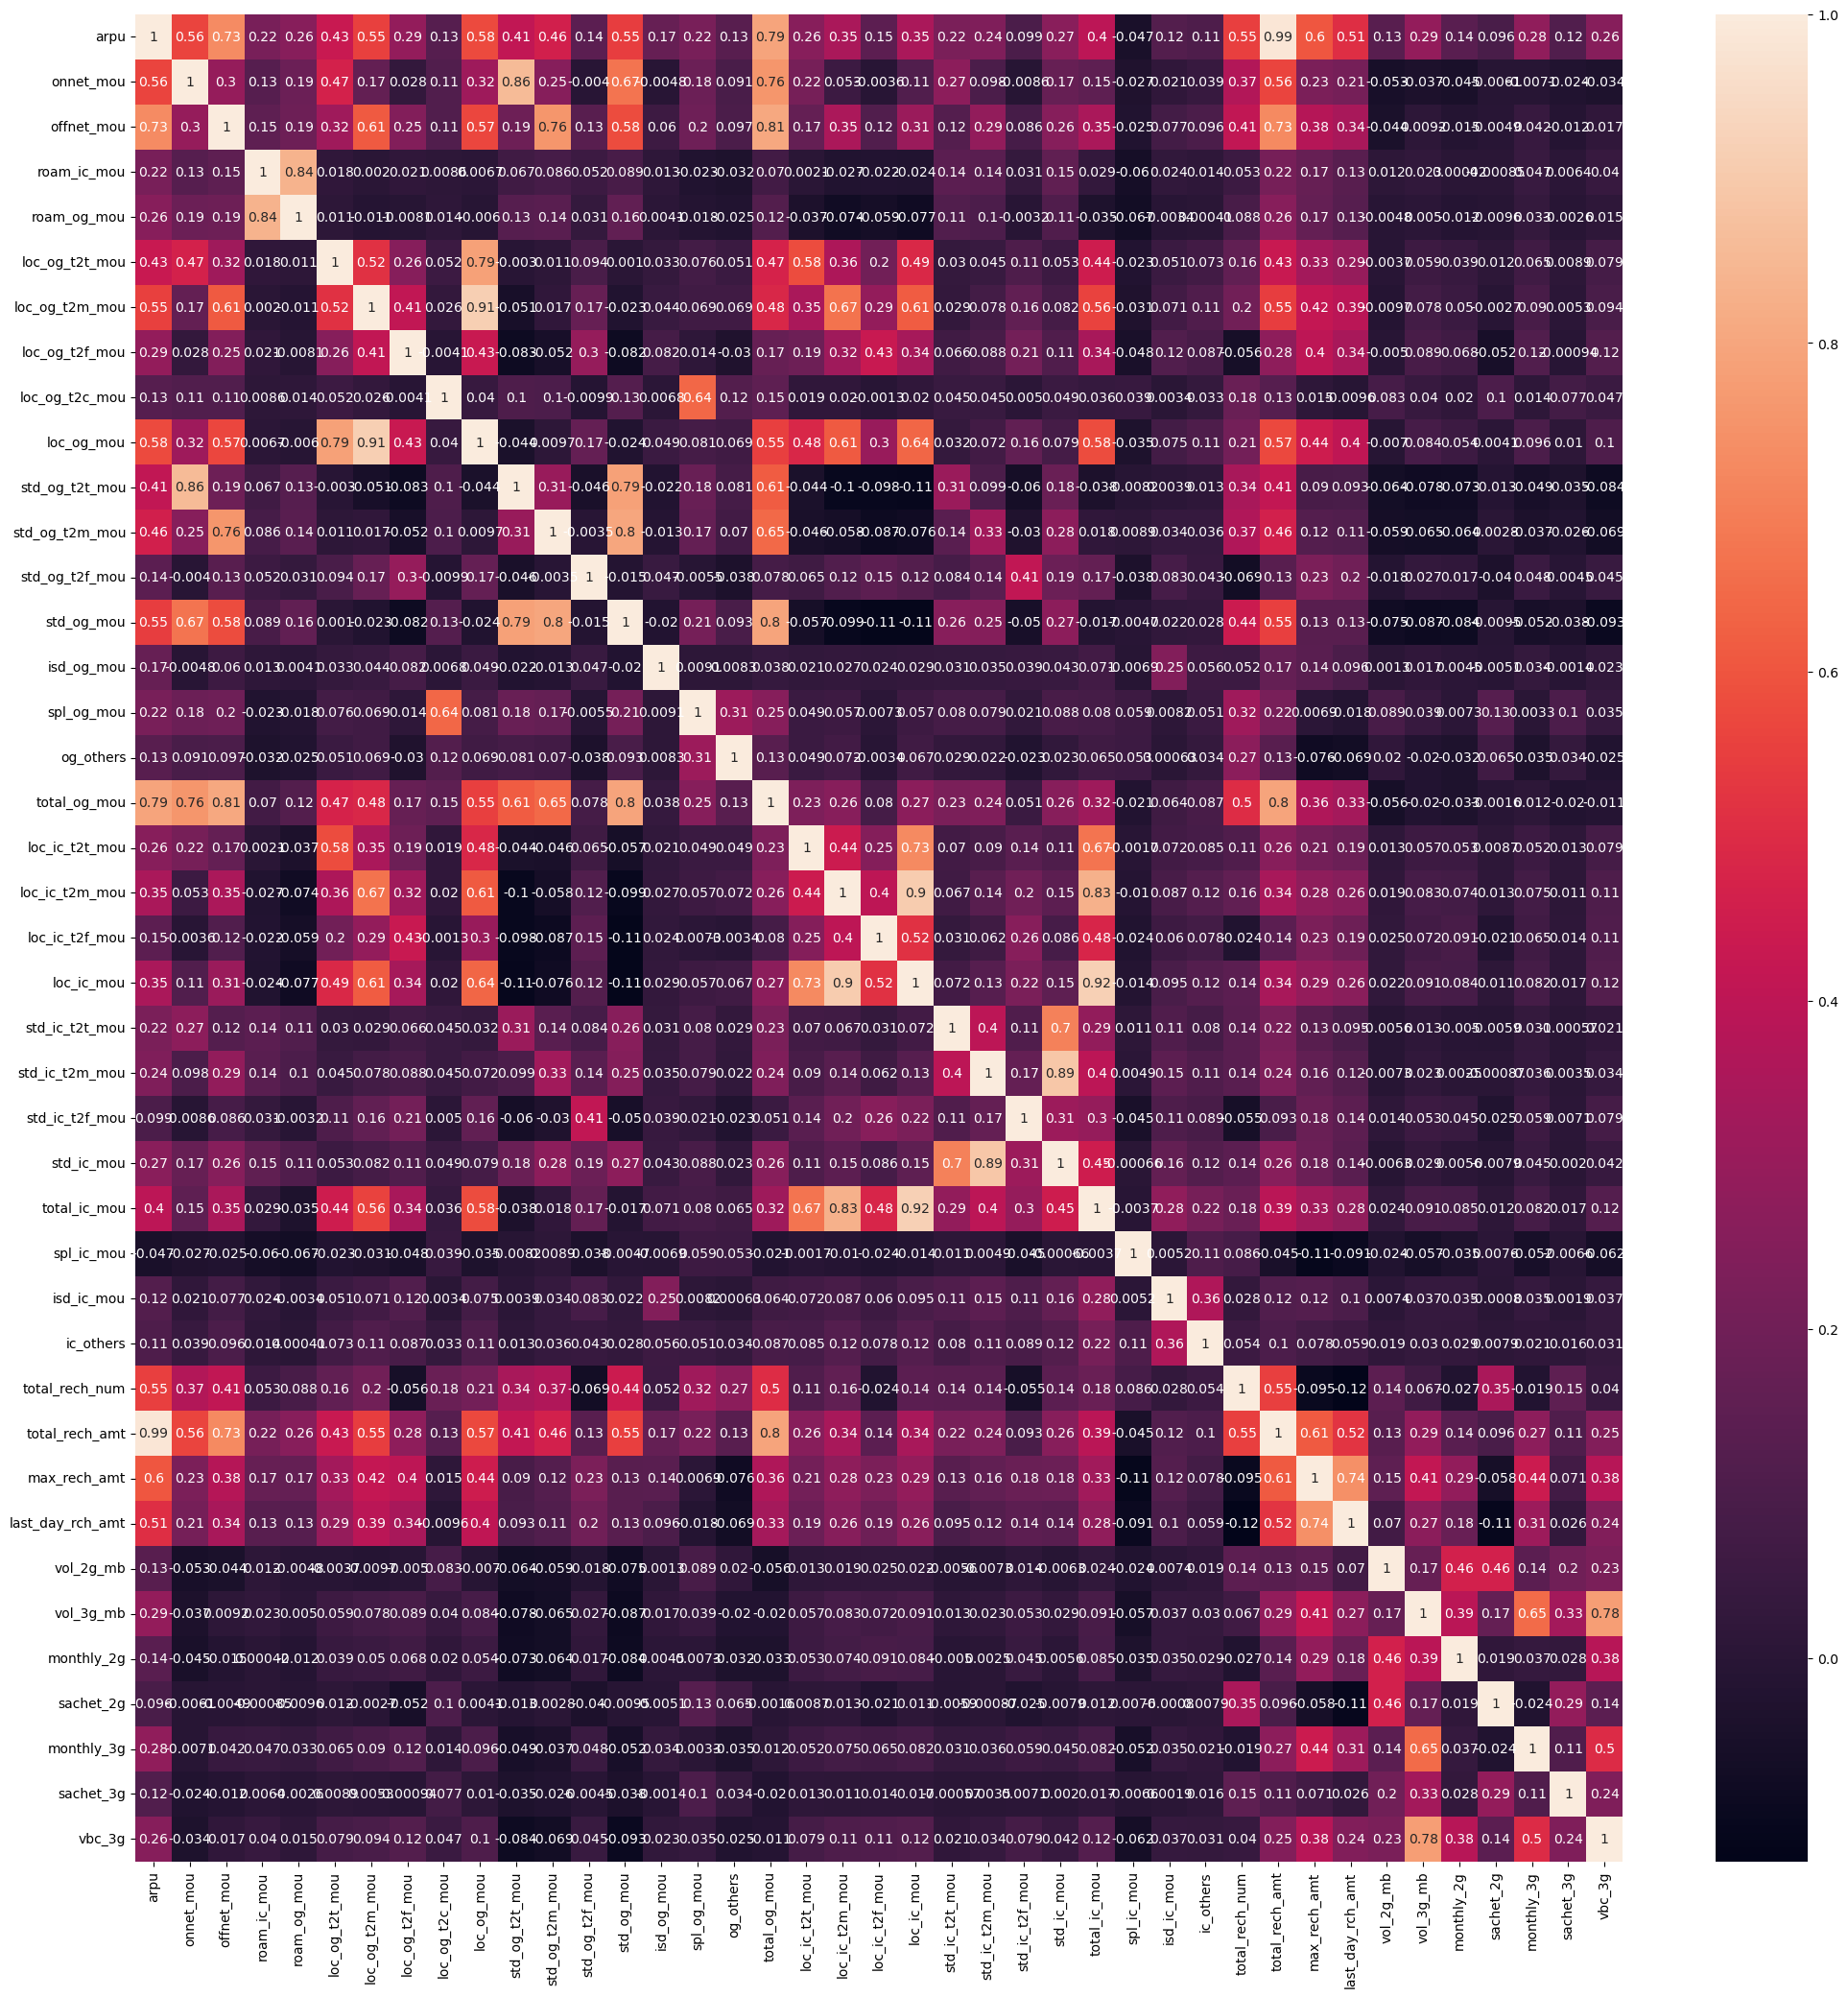

In [27]:
plt.figure(figsize=(25,25))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

### Insight:
- There are few features which are highly correlated to each other.  
- PCA will remove the multi collinearity.

# PCA

In [28]:
pca = PCA(random_state=100)
pca.fit(X_train)

PCA(random_state=100)

In [29]:
pca.components_

array([[ 3.02568048e-01,  1.89241884e-01,  2.58579430e-01, ...,
         7.76435790e-02,  2.43647235e-02,  7.95338616e-02],
       [ 1.04880084e-01,  2.36136969e-01,  1.26968699e-01, ...,
        -9.45038623e-02, -2.44851981e-02, -1.26988074e-01],
       [ 1.24445028e-01, -4.82626328e-02, -5.79999006e-02, ...,
         3.42928328e-01,  2.02780766e-01,  4.04523936e-01],
       ...,
       [ 6.83881219e-01, -6.03026136e-02,  2.29728805e-02, ...,
        -1.17519593e-02, -1.37619665e-03, -7.20666835e-03],
       [ 1.38152991e-02,  2.09022406e-01,  7.04229618e-02, ...,
        -4.70279325e-03, -3.04910966e-05,  2.68084380e-03],
       [-4.56203250e-03,  2.86988774e-01,  2.50548092e-01, ...,
        -2.37097064e-03, -3.22296035e-05,  1.81023394e-03]])

In [30]:
pca.explained_variance_ratio_

array([2.09075334e-01, 1.11954521e-01, 7.49653550e-02, 6.13193686e-02,
       5.50468006e-02, 4.06376265e-02, 3.67716601e-02, 3.40801371e-02,
       3.32198113e-02, 3.11811161e-02, 2.78207890e-02, 2.50107560e-02,
       2.42426412e-02, 2.30277430e-02, 2.21495461e-02, 2.11131690e-02,
       1.84669617e-02, 1.78932023e-02, 1.72731712e-02, 1.48704146e-02,
       1.38371975e-02, 1.26228793e-02, 1.20475814e-02, 1.09082668e-02,
       9.34836649e-03, 7.76683908e-03, 6.93086930e-03, 6.38962760e-03,
       5.35787133e-03, 3.85822436e-03, 3.17930058e-03, 2.72128972e-03,
       1.18799978e-03, 9.02878713e-04, 7.47767431e-04, 5.23662847e-04,
       4.77599967e-04, 3.42710632e-04, 3.15465522e-04, 2.68357581e-04,
       1.45119723e-04])

In [31]:
variance_cummulative = np.cumsum(pca.explained_variance_ratio_)
variance_cummulative

array([0.20907533, 0.32102985, 0.39599521, 0.45731458, 0.51236138,
       0.55299901, 0.58977067, 0.6238508 , 0.65707061, 0.68825173,
       0.71607252, 0.74108328, 0.76532592, 0.78835366, 0.81050321,
       0.83161637, 0.85008334, 0.86797654, 0.88524971, 0.90012012,
       0.91395732, 0.9265802 , 0.93862778, 0.94953605, 0.95888442,
       0.96665125, 0.97358212, 0.97997175, 0.98532962, 0.98918785,
       0.99236715, 0.99508844, 0.99627644, 0.99717932, 0.99792708,
       0.99845075, 0.99892835, 0.99927106, 0.99958652, 0.99985488,
       1.        ])

### scree plot

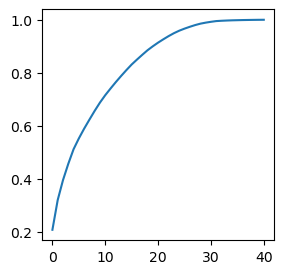

In [32]:
plt.figure(figsize=(3,3))
plt.plot(variance_cummulative)
plt.show()

### Insight:
- If we choose 25 variables, we can retain 95% of information.  
- So by selecting only 25 variables out of 41 variables, data loss is 5% 

In [33]:
# Choosing 25 variables out of 41 variables
pca = PCA(n_components=25, random_state=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_train.shape, X_test.shape

((55999, 25), (14000, 25))

# Correlation after PCA

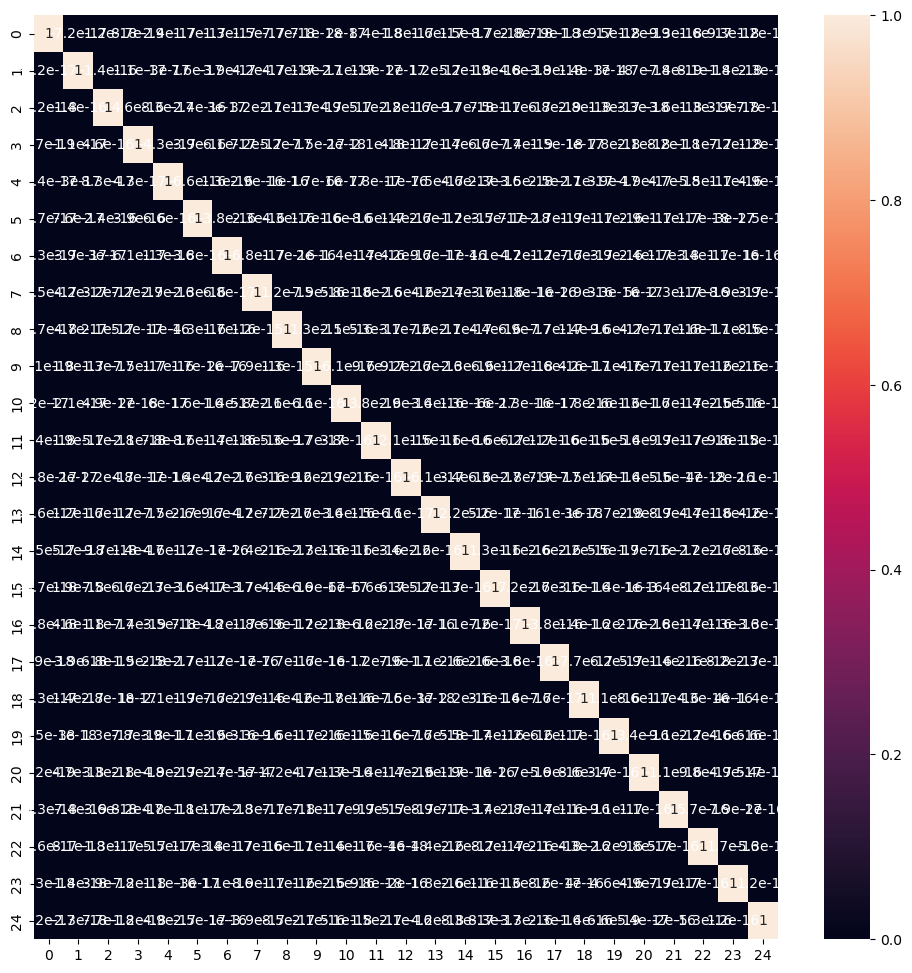

In [37]:
plt.figure(figsize=(12,12))
sns.heatmap(np.corrcoef(X_train.transpose()), annot=True)
plt.show()

### Insight:
- We can see that PCA has removed the multicollinearity in the features.
- And we dropped from 41 features to 25 features with retaining 95% data information

# Saving the data in file  
- So that I can run the notebook from here.  
- Delete these few lines later



In [61]:
# # Saving pca output in csv file
# np.savetxt('X_train_PCA_output.csv', X=X_train, delimiter=',', fmt='%f')

In [62]:
X_train = np.loadtxt('X_train_PCA_output.csv', delimiter=',')
X_train[:1,:]

array([[-3.220393, -0.267416, -0.768893, -0.180897, -0.720181, -0.138849,
        -0.10309 , -0.257033, -0.149509, -0.140965,  0.19278 ,  0.436008,
         0.022754, -0.363063,  0.386826,  0.265992, -0.304641, -0.540855,
         0.093602,  0.197309, -0.013214,  0.08058 ,  0.165219,  0.165249,
         0.688659]])

In [63]:
# np.savetxt('X_test_PCA_output.csv', X=X_test, delimiter=',', fmt='%f')

In [64]:
X_test = np.loadtxt('X_test_PCA_output.csv', delimiter=',')
X_test[:1,:]

array([[-1.15335 ,  2.985367, -0.404837, -0.954784,  0.329782, -0.148697,
         0.880579,  1.200678, -0.285082, -0.355571, -0.422965, -0.067902,
         0.67266 , -1.056494,  0.139933, -0.464362, -0.416842, -0.538887,
         0.246619, -0.180824, -0.08942 ,  0.335719,  0.253902, -0.082015,
         0.282404]])

In [65]:
# y_train.to_csv('y_train_PCA_output.csv', index=False)

In [66]:
y_train = pd.read_csv('y_train_PCA_output.csv', squeeze=True)
y_train.head()

0    1
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: int64

In [67]:
# y_test.to_csv('y_test_PCA_output.csv', index=False)
y_test = pd.read_csv('y_test_PCA_output.csv', squeeze=True)
y_test.head()

0    1
1    1
2    0
3    0
4    1
Name: churn_probability, dtype: int64

# Model Building

### Logistic Regression